In [8]:
import torch, torchvision
import torchvision.transforms.v2 as transforms_v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from metrics.utils import frechet_inception_distance
from models import ResNet18_LowRes
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
import ood_detectors.vision as vision_ood
import ood_detectors.likelihood as likelihood
import ood_detectors.residual as residual
import ood_detectors.eval_utils as eval_utils
import pathlib
import datasets as ds
import db_logger
from copy import deepcopy
import random, json
from ood_metrics import get_encoder_transform, plot

%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
conf = {} 
dataset = 'BloodMNIST'
encoder_name = 'dinov2'
size = conf.get('size', 224)

device = conf.get('device', 'cuda')
seed = conf.get('seed', None)

super_sample = conf.get('super_sample', 10)
balanced_lvl = conf.get('balanced_lvl', 0)
reduce_level = conf.get('reduce_level', 1)
root_dir = "/mnt/data/arty/data/gan_sampling/"
data_dir = pathlib.Path(root_dir)/"data"
data_dir.mkdir(exist_ok=True, parents=True)
data_blob = ds.get_dataset(dataset, f"{root_dir}/data",reduce_level=reduce_level, size=size)
encoder = vision_ood.get_encoder(encoder_name)
encoder.eval()
encoder.to(device)
encoder_transform = get_encoder_transform(encoder, device=device)

train_transform_1, test_transform = ds.get_dataset_aug(dataset=dataset, aug_lvl=1)
train_transform_1.transforms.pop()
train_transform_2, test_transform = ds.get_dataset_aug(dataset=dataset, aug_lvl=2)
train_transform_2.transforms.pop()
test_transform.transforms.pop()
num_classes = data_blob['num_classes']

embs = {
    "train": [[] for _ in range(num_classes)],
    "train_alvl1": [[] for _ in range(num_classes)],
    "train_alvl2": [[] for _ in range(num_classes)],
    "test": [[] for _ in range(num_classes)],
}
        
data = {
    "train": [[] for _ in range(num_classes)],
    "test": [[] for _ in range(num_classes)],
}
for img, l in data_blob["train"]:
    data["train"][l].append(img)

for img, l in data_blob["test"]:
    data["test"][l].append(img)

print("Embed imgs")
for c, d in enumerate(data["train"]):
    loader = torch.utils.data.DataLoader(d, batch_size=16, shuffle=False)
    with torch.no_grad():
        for _ in range(super_sample):
            for img in loader:
                img_ = encoder_transform(train_transform_1(img.to(device)))
                emb = encoder(img_)
                embs["train_alvl1"][c].append(emb.cpu())
                img_ = encoder_transform(test_transform(img.to(device)))
                emb = encoder(img_)
                embs["train_alvl2"][c].append(emb.cpu())
        for img in loader:
                img = encoder_transform(img.to(device))
                emb = encoder(img)
                embs["train"][c].append(emb.cpu())
    embs["train"][c] = torch.concatenate(embs["train"][c])
    embs["train_alvl1"][c] = torch.concatenate(embs["train_alvl1"][c])
    embs["train_alvl2"][c] = torch.concatenate(embs["train_alvl2"][c])
for c, d in enumerate(data["test"]):
    loader = torch.utils.data.DataLoader(d, batch_size=16, shuffle=False)
    with torch.no_grad():
        for img in loader:
            img = encoder_transform(img.to(device))
            emb = encoder(img)
            embs["test"][c].append(emb.cpu())
    embs["test"][c] = torch.concatenate(embs["test"][c])


Using cache found in /home/arty/.cache/torch/hub/facebookresearch_dinov2_main


Embed imgs


In [5]:
print("fitt ood")
ood_detectors = [residual.ResidualAuto() for _ in range(num_classes)]

for i, ood_detector in enumerate(ood_detectors):
    ood_detector.to(device)
    ood_detector.fit(embs["train"][i], embs["test"][i], torch.concatenate([embs["train"][j] for j in range(num_classes) if i != j]), batch_size=1000, n_epochs=10, verbose=False)
    ood_detector.to("cpu")

ood_detectors_alvl1 = [residual.ResidualAuto() for _ in range(num_classes)]

for i, ood_detector in enumerate(ood_detectors_alvl1):
    ood_detector.to(device)
    ood_detector.fit(embs["train_alvl1"][i], embs["test"][i], torch.concatenate([embs["train_alvl1"][j] for j in range(num_classes) if i != j]), batch_size=1000, n_epochs=10, verbose=False)
    ood_detector.to("cpu")

ood_detectors_alvl2 = [residual.ResidualAuto() for _ in range(num_classes)]

for i, ood_detector in enumerate(ood_detectors_alvl2):
    ood_detector.to(device)
    ood_detector.fit(embs["train_alvl2"][i], embs["test"][i], torch.concatenate([embs["train_alvl2"][j] for j in range(num_classes) if i != j]), batch_size=1000, n_epochs=10, verbose=False)
    ood_detector.to("cpu")


fitt ood


calc scores
Generating plots... figs/send_plot_ResidualAutoDim8_dinov2_0_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim16_dinov2_1_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim16_dinov2_2_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim56_dinov2_3_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim8_dinov2_4_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim8_dinov2_5_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim8_dinov2_6_224_test.png
Generating plots... figs/send_plot_ResidualAutoDim8_dinov2_7_224_test.png


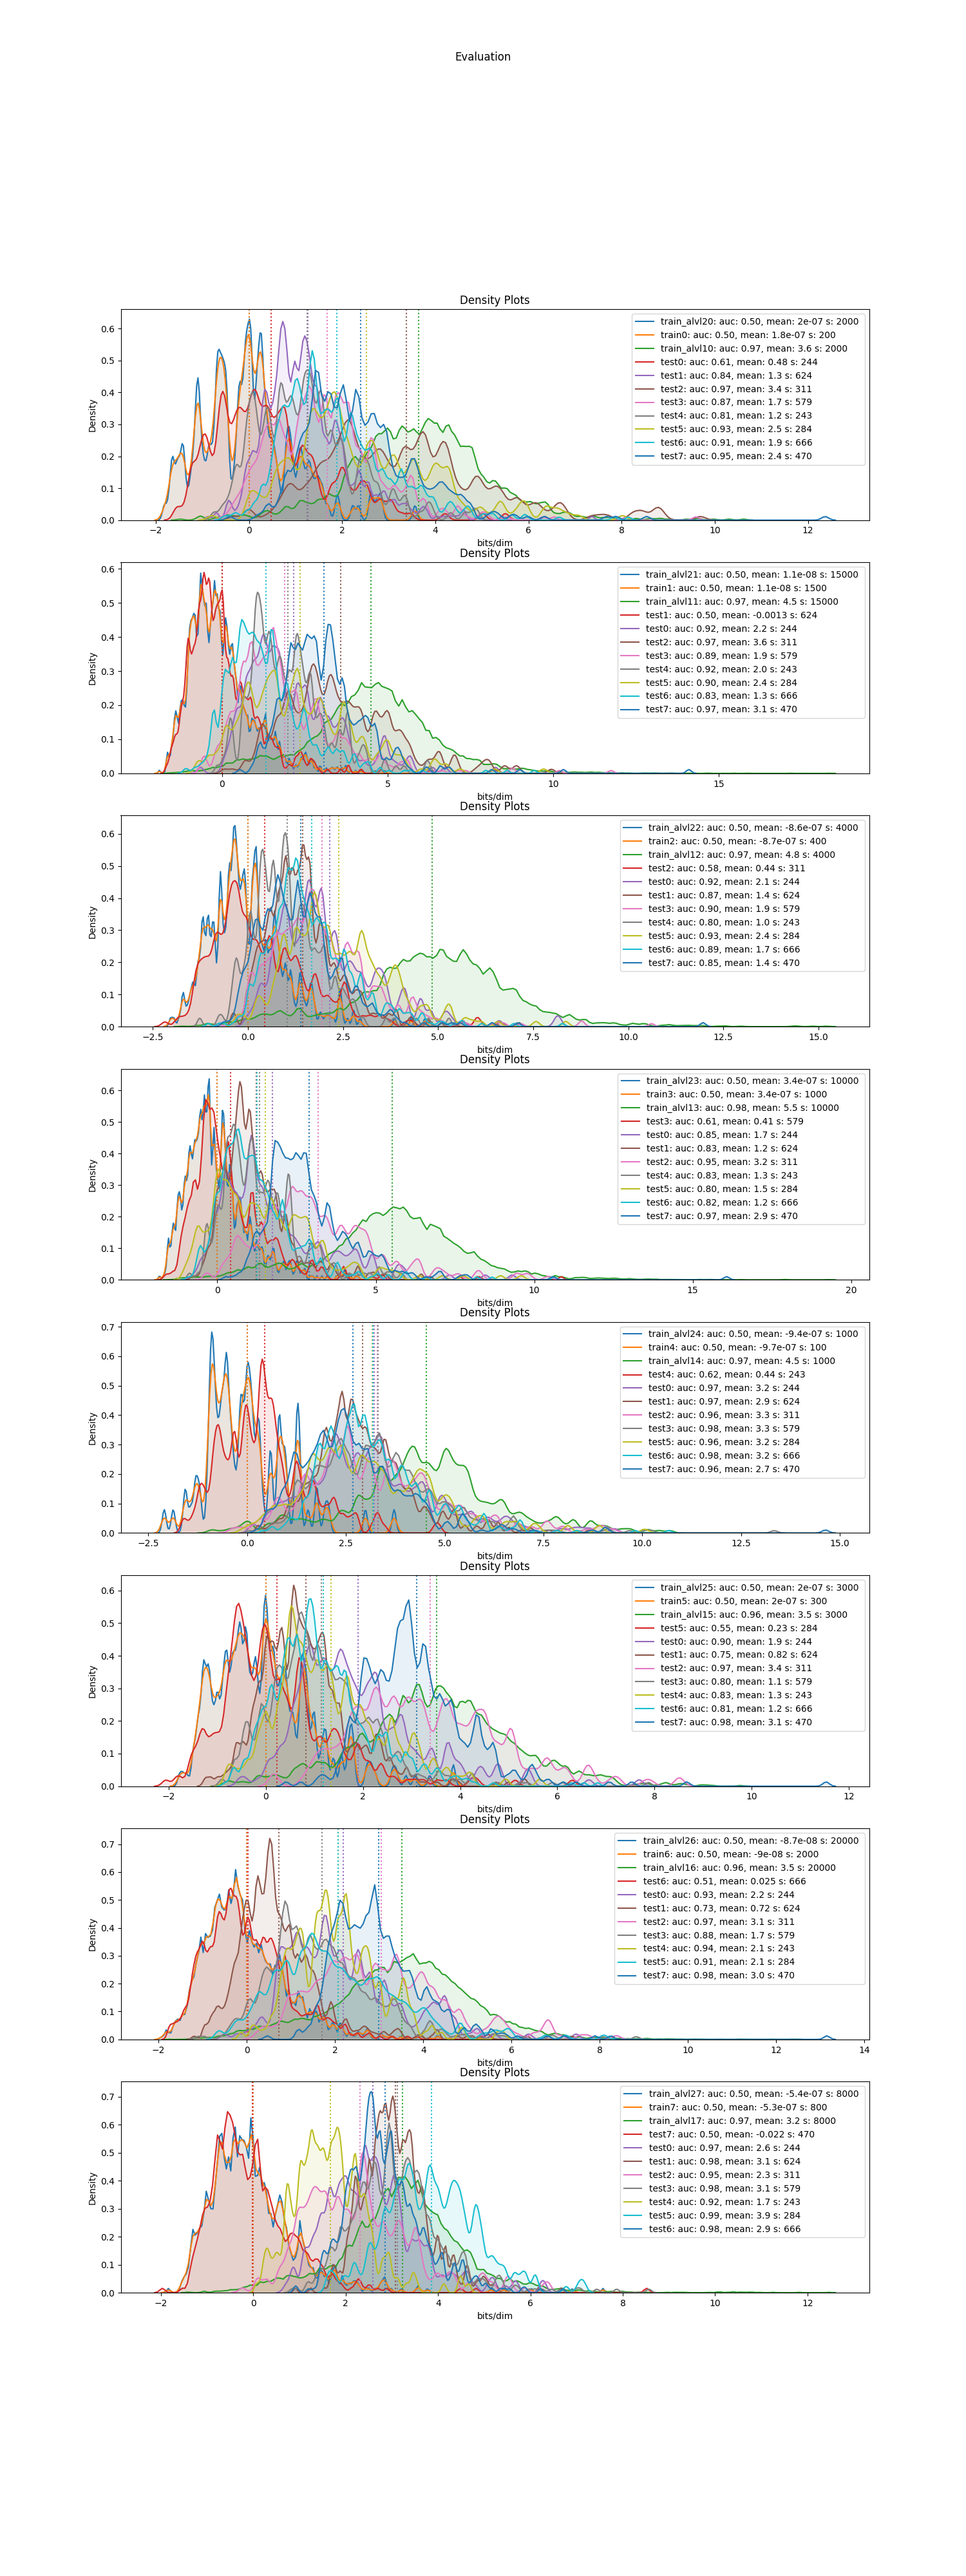

In [17]:
scores = {
    "train": [[None]*num_classes for _ in range(num_classes)],
    "train_alvl1": [[None]*num_classes for _ in range(num_classes)],
    "train_alvl2": [[None]*num_classes for _ in range(num_classes)],
    "test": [[None]*num_classes for _ in range(num_classes)],
}
print("calc scores")
for i, ood_detector in enumerate(ood_detectors_alvl2):
    for j in range(num_classes):
        ood_detector.to(device)
        for name in ["train", "train_alvl1", "train_alvl2", "test"]:
            score = ood_detector.predict(embs[name][j], batch_size=1000, verbose=False)
            score = torch.from_numpy(score)
            scores[name][i][j] = score
        ood_detector.to("cpu")
fig, ax = plt.subplots(num_classes, 1, figsize=(15, 5*num_classes))  # Adjust the size as needed
fig.suptitle(f'Evaluation')
first = "train_alvl2"
for i in range(num_classes):
    scores_class = [scores[first][i][i].numpy()]+[scores[name][i][i].numpy() for name in scores.keys() if name != first] + [scores["test"][i][j].numpy() for j in range(num_classes) if i != j]
    names = [f"{first}{i}"] + [f"{n}{i}" for n in scores.keys() if n != first] + [f"test{j}" for j in range(num_classes) if i != j]
    res = plot(scores_class,f"send_plot_{ood_detectors[i].name}_{encoder_name}_{i}_{size}_test", out_dir="figs",names=names, fig=fig, ax=ax[i])